<a href="https://colab.research.google.com/github/abbygomez00/beginning-bioinformatics/blob/main/FinalBioinformaticsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --quiet numcodecs==0.12.1 zarr==2.15.0
!pip install --quiet anndata==0.11.1 scanpy==1.10.1
!pip install --quiet python-igraph leidenalg


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 85.4 MB/s eta 0:00:00


Imports


In [4]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np


/usr/local/lib/python3.12/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

Define Gene Sets


In [7]:
emt_genes = [
    "SNAI1","SNAI2","TWIST1","ZEB1","ZEB2","SOX9","VIM","FN1",
    "ITGA5","ITGB1","COL1A1","COL1A2","COL3A1","LAMC2","MMP2","MMP9",
    "PDGFRB","CDH2","TAGLN"
]

epi_genes = ["CDH1","EPCAM","KRT8","KRT18","KRT19"]
gbm_lineage = ["SOX2","OLIG2","PDGFRA","EGFR","AQP4","GFAP"]

gene_keep = set(emt_genes + epi_genes + gbm_lineage)
print("Total genes to keep:", len(gene_keep))


Total genes to keep: 30


Stream-load TPM file


In [9]:
file = "/content/GSM3828673_10X_GBM_IDHwt_processed_TPM.tsv.gz"

chunks = []
for chunk in pd.read_csv(file, sep="\t", index_col=0, chunksize=1000):
    sub = chunk[chunk.index.isin(gene_keep)]
    if not sub.empty:
        chunks.append(sub)

df_small = pd.concat(chunks)
print("df_small shape (genes x cells):", df_small.shape)
print("Genes in df_small:", list(df_small.index))


df_small shape (genes x cells): (30, 16201)
Genes in df_small: ['LAMC2', 'EPCAM', 'ZEB2', 'COL3A1', 'FN1', 'SOX2', 'PDGFRA', 'PDGFRB', 'TWIST1', 'EGFR', 'COL1A2', 'SNAI2', 'VIM', 'ZEB1', 'ITGB1', 'TAGLN', 'KRT8', 'KRT18', 'ITGA5', 'MMP2', 'CDH1', 'KRT19', 'GFAP', 'COL1A1', 'SOX9', 'AQP4', 'CDH2', 'MMP9', 'SNAI1', 'OLIG2']


Build AnnData and run UMAP + Leiden


AnnData object with n_obs × n_vars = 16201 × 30


/tmp/ipython-input-3353984962.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


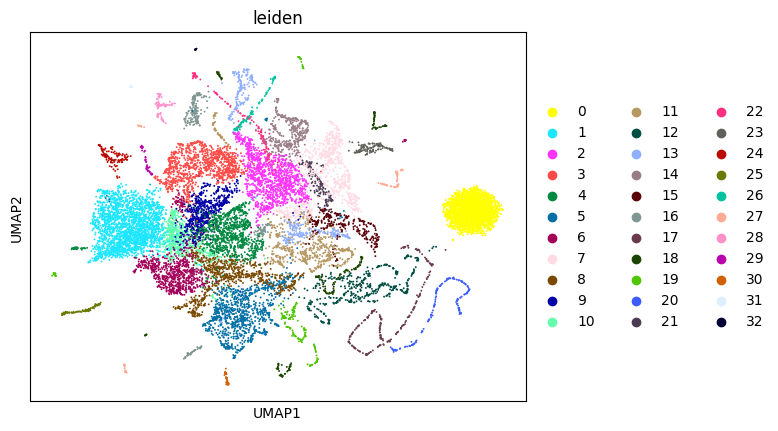

In [10]:
# df_small: genes x cells
adata = sc.AnnData(df_small.T)  # cells x genes
adata.var_names_make_unique()
adata.obs_names_make_unique()

print(adata)

# basic clustering pipeline
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=min(10, adata.n_vars))
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# UMAP colored by cluster
sc.pl.umap(adata, color="leiden")


Compute EMT_score manually from TPM


In [12]:
# use only EMT genes that are present in df_small
present_emt = [g for g in emt_genes if g in df_small.index]
print("EMT genes used:", present_emt)

emt_expr = df_small.loc[present_emt]    # genes x cells
emt_score = emt_expr.mean(axis=0)       # one score per cell

# align with AnnData cells
emt_score = emt_score.reindex(adata.obs_names)
adata.obs["EMT_score"] = emt_score.values

print(adata.obs["EMT_score"].describe())


EMT genes used: ['SNAI1', 'SNAI2', 'TWIST1', 'ZEB1', 'ZEB2', 'SOX9', 'VIM', 'FN1', 'ITGA5', 'ITGB1', 'COL1A1', 'COL1A2', 'COL3A1', 'LAMC2', 'MMP2', 'MMP9', 'PDGFRB', 'CDH2', 'TAGLN']
count    16201.000000
mean       146.202287
std        209.927691
min          0.000000
25%         12.157907
50%         55.941448
75%        200.827110
max       2221.770643
Name: EMT_score, dtype: float64


Plot EMT_score on UMAP and by cluster

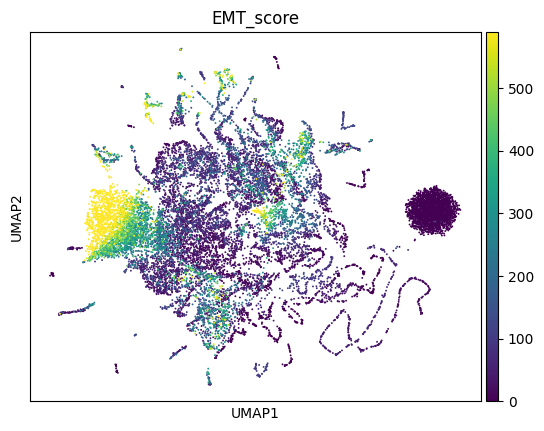

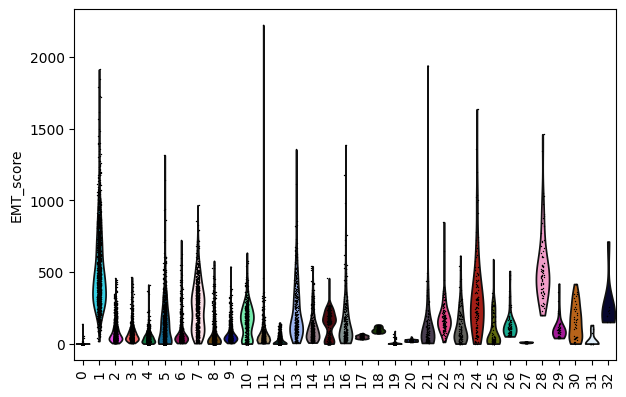

In [13]:
low = np.nanpercentile(adata.obs["EMT_score"], 5)
high = np.nanpercentile(adata.obs["EMT_score"], 95)

sc.pl.umap(
    adata,
    color="EMT_score",
    cmap="viridis",
    vmin=low,
    vmax=high
)

sc.pl.violin(
    adata,
    "EMT_score",
    groupby="leiden",
    rotation=90
)


Identify High-EMT Clusters

In [14]:
# Rank clusters by median EMT score
cluster_medians = (
    adata.obs
    .groupby("leiden")["EMT_score"]
    .median()
    .sort_values(ascending=False)
)

print("Median EMT score per cluster (highest → lowest):")
print(cluster_medians)

# The highest EMT cluster:
top_cluster = cluster_medians.index[0]
print("\nCluster with highest EMT score:", top_cluster)


Median EMT score per cluster (highest → lowest):
leiden
28    478.683418
1     451.612980
24    254.054283
7     253.046304
32    213.949508
10    163.283078
22    160.684809
13    159.376297
30    151.062588
15    149.997838
5     116.778537
26    109.992850
18     94.604396
29     85.095520
23     84.342206
14     83.075586
16     81.221572
21     62.704822
2      56.796668
3      51.437497
17     48.823357
9      46.063674
6      40.500111
25     33.673435
4      31.876999
11     31.525354
8      24.417500
20     21.866049
12     11.878930
27      9.360053
0       0.000000
19      0.000000
31      0.000000
Name: EMT_score, dtype: float64

Cluster with highest EMT score: 28


/tmp/ipython-input-3797459674.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("leiden")["EMT_score"]


In [16]:
import pandas as pd

emt_cluster_means = (
    adata.to_df()[present_emt]
    .join(adata.obs["leiden"])
    .groupby("leiden")
    .mean()
)

emt_cluster_means = emt_cluster_means.loc[cluster_medians.index]  # reorder by EMT score
emt_cluster_means


/tmp/ipython-input-3612842443.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("leiden")


,SNAI1,SNAI2,TWIST1,ZEB1,ZEB2,SOX9,VIM,FN1,ITGA5,ITGB1,COL1A1,COL1A2,COL3A1,LAMC2,MMP2,MMP9,PDGFRB,CDH2,TAGLN
leiden,,,,,,,,,,,,,,,,,,,
28,-0.017002,0.531168,-0.020096,-0.140441,0.040541,-0.240911,0.459972,8.892638,0.306659,1.586041,1.461475,-0.052989,-0.003078,-0.019106,0.224306,0.781551,0.108058,-0.304998,-0.101205
1,-0.035696,0.150698,-0.020590,0.314859,-0.091853,1.705966,1.737276,-0.098411,-0.026573,0.931605,-0.028084,-0.070123,-0.019005,-0.012321,0.052686,-0.039013,-0.017136,0.867758,-0.106632
24,0.110045,0.019741,-0.030091,-0.201667,-0.037608,-0.282851,0.930413,0.636026,0.085677,0.313733,-0.032947,-0.072984,-0.024163,-0.019106,-0.013839,-0.036922,0.037065,-0.295102,-0.106168
7,0.005561,-0.083672,-0.033720,-0.254189,-0.060103,-0.380931,0.535026,1.514748,0.029099,-0.207010,-0.031568,-0.059134,-0.019465,-0.018091,-0.208036,-0.024718,-0.029784,-0.403366,-0.071807
32,-0.037732,-0.090843,-0.034352,-0.283123,0.316633,-0.425594,0.712024,-0.193282,-0.099714,-0.383518,-0.039142,-0.072984,-0.024163,-0.019106,-0.292875,-0.066041,-0.052407,-0.431326,-0.116836
10,-0.025869,0.017351,-0.020090,0.408496,-0.055716,0.114694,0.065635,-0.150207,-0.003019,-0.249760,-0.037915,-0.068108,-0.024163,-0.016748,0.361354,-0.064660,0.321916,0.838907,-0.110948
22,-0.028753,-0.080768,-0.032493,-0.252213,0.052618,-0.325117,-0.080142,-0.110185,-0.041468,0.144777,-0.031487,-0.072984,-0.024163,-0.012155,-0.054022,4.225027,-0.025213,-0.393871,-0.113224
13,-0.037732,-0.057234,-0.020178,-0.262046,-0.143495,-0.401802,-0.222935,-0.048597,-0.014500,-0.283096,-0.022245,-0.061644,0.002497,-0.007773,-0.289620,-0.054551,0.009738,-0.378426,3.674899
30,-0.020149,-0.090843,0.033498,0.023613,0.260054,0.117878,0.015587,0.301050,-0.076816,-0.095579,-0.020488,0.271986,0.030280,-0.019106,-0.251730,-0.066041,-0.028821,0.110338,-0.096911
